# Setup

In [3]:
import Pkg
Pkg.add("CUDA")
Pkg.add("cuDNN")
Pkg.add("Flux")
Pkg.add("NNlib")
Pkg.add("Graphs")
Pkg.add("GraphNeuralNetworks")
Pkg.add("SparseArrays")
Pkg.add("Images")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed LoggingExtras ────── v1.1.0
   Installed TimerOutputs ─────── v0.5.25
   Installed PlotUtils ────────── v1.4.2
   Installed StaticArrays ─────── v1.9.8
   Installed GR_jll ───────────── v0.73.8+0
   Installed LERC_jll ─────────── v4.0.0+0
   Installed TiffImages ───────── v0.10.2
   Installed Cairo_jll ────────── v1.18.2+1
   Installed Distances ────────── v0.10.12
   Installed Polynomials ──────── v4.0.11
   Installed CUDA_Runtime_jll ─── v0.15.3+0
   Installed CUDA_Driver_jll ──── v0.10.3+0
   Installed LLVM ─────────────── v9.1.3
   Installed FileIO ───────────── v1.16.4
   Installed SentinelArrays ───── v1.4.6
   Installed Bzip2_jll ────────── v1.0.8+2
   Installed TranscodingStreams ─ v0.11.3
   Installed Zygote ───────────── v0.6.72
   Installed Libtiff_jll ──────── v4.7.0+0
   Installed Adapt ────────────── v4.1.0
   Installed JLLWrappers ──────── v1.6.1
   Installed MLDataD

In [4]:
Pkg.add("Plots")
Pkg.add("GraphsPlots")
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/Documents/graph-segmentation/Project.toml`
  No Changes to `~/Documents/graph-segmentation/Manifest.toml`


Pkg.Types.PkgError: The following package names could not be resolved:
 * GraphsPlots (not found in project, manifest or registry)
[36m   Suggestions:[39m Li[0m[1mg[22mhtG[0m[1mr[22m[0m[1ma[22m[0m[1mp[22m[0m[1mh[22m[0m[1ms[22mGra[0m[1mp[22mhB[0m[1mL[22mAS

# Julia for GNNs

Using [GraphNeuralNetworks.jl](https://carlolucibello.github.io/GraphNeuralNetworks.jl/stable/)

In [1]:
using Graphs, GraphNeuralNetworks
import Images

using  BenchmarkTools

In [3]:
dims = (128, 128)

(128, 128)

In [33]:
x

3×16384 reshape(reinterpret(reshape, FixedPointNumbers.N0f8, ::Array{RGB{N0f8},2}), 3, 16384) with eltype FixedPointNumbers.N0f8:
 0.596  0.918  0.886  0.886  0.659  …  0.745  0.722  0.482  0.012  0.0
 0.588  0.89   0.863  0.859  0.627     0.722  0.706  0.478  0.016  0.0
 0.596  0.878  0.839  0.851  0.643     0.761  0.729  0.463  0.008  0.004

In [57]:
function rag(dims::Tuple{Int, Int})
    pixel_index(x, y, width) = (y-1)*width + x

    neighbor_offsets = [
        (-1, 0), (1, 0),  # Left and right
        (0, -1), (0, 1),  # Up and down
        (-1, -1), (1, -1),  # Diagonal up-left and up-right
        (-1, 1), (1, 1)   # Diagonal down-left and down-right
    ]
    
    N = dims[1]*dims[2]
    E = 8*N - 6*(dims[1] + dims[2]) + 4
    src, dst = Vector{Int64}(undef, E), Vector{Int64}(undef, E)

    edge_index = 1
    @inbounds for y in 1:dims[1]
        for x in 1:dims[2]
            current_pixel = pixel_index(x, y, dims[2])
            for (dx, dy) in neighbor_offsets
                nx, ny = x + dx, y + dy
                if 1 <= nx <= dims[2] && 1 <= ny <= dims[1]
                    neighbor_pixel = pixel_index(nx, ny, dims[2])
                    src[edge_index] = current_pixel
                    dst[edge_index] = neighbor_pixel
                    edge_index += 1
                end
            end
        end
    end
         
    return GNNGraph(src, dst, num_nodes=N)
end

rag (generic function with 3 methods)

In [59]:
@btime g = rag(dims)

  555.030 μs (21 allocations: 1.98 MiB)


GNNGraph:
  num_nodes: 16384
  num_edges: 129540

In [60]:
g = rag(dims)


GNNGraph:
  num_nodes: 16384
  num_edges: 129540

In [ ]:
edge_index(g)

In [184]:
g.x[:, 288]

3-element Array{N0f8,1} with eltype N0f8:
 0.145N0f8
 0.086N0f8
 0.306N0f8

In [63]:
g.ndata.x = x

3×16384 reshape(reinterpret(reshape, FixedPointNumbers.N0f8, ::Array{RGB{N0f8},2}), 3, 16384) with eltype FixedPointNumbers.N0f8:
 0.596  0.918  0.886  0.886  0.659  …  0.745  0.722  0.482  0.012  0.0
 0.588  0.89   0.863  0.859  0.627     0.722  0.706  0.478  0.016  0.0
 0.596  0.878  0.839  0.851  0.643     0.761  0.729  0.463  0.008  0.004

In [64]:
@btime w = compute_edge_weights(g)

  3.935 ms (86 allocations: 3.34 MiB)


1×129540 Matrix{Float64}:
 0.701961  0.942484  0.818301  0.301961  …  0.993464  0.860131  0.828758

In [41]:
g.e ./ 3

129540-element Vector{Float64}:
 0.7019607843137255
 0.942483660130719
 0.8183006535947713
 0.30196078431372547
 0.032679738562091505
 0.11633986928104574
 0.24052287581699347
 0.14640522875816994
 0.9712418300653595
 0.33202614379084966
 ⋮
 0.2980392156862745
 0.5411764705882353
 0.01045751633986928
 0.8392156862745098
 0.8888888888888888
 0.8705882352941177
 0.9934640522875817
 0.8601307189542484
 0.8287581699346406

In [74]:
w = compute_edge_weights(g)
@btime compute_edge_weights(g)

  3.937 ms (81 allocations: 2.35 MiB)


1×129540 Matrix{Float64}:
 0.701961  0.942484  0.818301  0.301961  …  0.993464  0.860131  0.828758

In [65]:
g.edata.e = w
g.e

1×129540 Matrix{Float64}:
 0.701961  0.942484  0.818301  0.301961  …  0.993464  0.860131  0.828758

In [73]:
function compute_edge_weights(g::GNNGraph)
    src, dst = edge_index(g)
    x_dim = size(g.x, 1)

    w = @views sum(abs.(g.x[:, src] .- g.x[:, dst]), dims=1) ./ x_dim

    return w
end

compute_edge_weights (generic function with 1 method)

In [60]:
using  GraphPlot

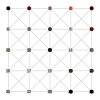

In [139]:

layout_i = vec(reshape([i for i in 1:dims[1], j in 1:dims[2]], (dims[1]*dims[2], 1)))
layout_j = vec(reshape([j for i in 1:dims[1], j in 1:dims[2]], (dims[1]*dims[2], 1)))
gplot(g, layout_i, layout_j, nodelabel=1:25, nodesize=50, nodelabelsize=10, nodefillc=img_vec)

In [6]:
N*8

129032

In [110]:
img_vec = vec(reshape(img, dims[1]*dims[2], :))

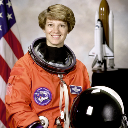

In [4]:
img = Images.load("data/astronaut.png")
img = Images.RGB.(img)
img = Images.imresize(img, dims)

In [72]:
x = Images.channelview(img) # CxHxW
x = reshape(x, (3, dims[1]*dims[2]))

3×16384 reshape(reinterpret(reshape, FixedPointNumbers.N0f8, ::Array{RGB{N0f8},2}), 3, 16384) with eltype FixedPointNumbers.N0f8:
 0.596  0.918  0.886  0.886  0.659  …  0.745  0.722  0.482  0.012  0.0
 0.588  0.89   0.863  0.859  0.627     0.722  0.706  0.478  0.016  0.0
 0.596  0.878  0.839  0.851  0.643     0.761  0.729  0.463  0.008  0.004

# Felzenszwalb implementation (basic)

The implementation from ImageSegmentation.jl

In [ ]:

"""
    index_map, num_segments = felzenszwalb(edges, num_vertices, k, min_size=0)

Segment an image represented as Region Adjacency Graph(RAG) using Felzenszwalb's segmentation algorithm. Each pixel/region
corresponds to a node in the graph and weights on each edge measure the dissimilarity between pixels.
The function returns the number of segments and index mapping from nodes of the RAG to segments.

Parameters:
- `edges`:        Array of edges in RAG. Each edge is represented as `ImageEdge`.
- `num_vertices`: Number of vertices in RAG
- `k`:            Threshold for region merging step. Larger threshold will result in bigger segments.
- `min_size`:     Minimum segment size (in # pixels)
"""
function felzenszwalb(edges::Array{ImageEdge}, num_vertices::Int, k::Float64, min_size::Int = 0)

    num_edges = length(edges)
    G = IntDisjointSets(num_vertices)
    set_size = ones(num_vertices)
    threshold = fill(convert(Float64,k), num_vertices)

    sort!(edges, lt = (x,y)->(x.weight<y.weight))

    for edge in edges
        w = edge.weight
        a = find_root!(G, edge.index1)
        b = find_root!(G, edge.index2)
        if a!=b
            if w <= min(threshold[a], threshold[b])
                merged_root = union!(G, a, b)
                set_size[merged_root] = set_size[a] + set_size[b]
                threshold[merged_root] = w + k/set_size[merged_root]
            end
        end
    end

    #merge small segments
    for edge in edges
        a = find_root!(G, edge.index1)
        b = find_root!(G, edge.index2)
        if a!=b && (set_size[a] < min_size || set_size[b] < min_size)
            union!(G, a, b)
        end
    end

    segments = OrderedSet{Int}()
    for i in 1:num_vertices
        push!(segments, find_root!(G, i))
    end

    num_sets = length(segments)
    segments2index = Dict{Int, Int}()
    for (i, s) in enumerate(segments)
        segments2index[s] = i
    end

    index_map = Vector{Int}(undef, num_vertices)
    for i in 1:num_vertices
        index_map[i] = segments2index[find_root!(G, i)]
    end

    return index_map, num_sets
end

In [94]:
using DataStructures

function felzenszwalb(g::GNNGraph, k::Float64)
    G = IntDisjointSets(g.num_nodes)
    set_size = ones(g.num_nodes)
    threshold = fill(k, g.num_nodes)

    edges = collect(edge_index(g))
    sort!(edges, lt = (i,j)->(g.e[i]<g.e[j]))

    @inbounds for edge in 1:g.num_edges
        w = g.e[edge]
        a = find_root!(G, edges[1][edge])
        b = find_root!(G, edges[2][edge])
        if a!=b
            if w <= min(threshold[a], threshold[b])
                merged_root = union!(G, a, b)
                set_size[merged_root] = set_size[a] + set_size[b]
                threshold[merged_root] = w + k/set_size[merged_root]
            end
        end
    end
    
    segments = OrderedSet{Int}()
    for i in 1:g.num_nodes
        push!(segments, find_root!(G, i))
    end

    num_sets = length(segments)
    segments2index = Dict{Int, Int}()
    for (i, s) in enumerate(segments)
        segments2index[s] = i
    end

    index_map = Vector{Int}(undef, g.num_nodes)
    for i in 1:g.num_nodes
        index_map[i] = segments2index[find_root!(G, i)]
    end

    return index_map, num_sets
end

felzenszwalb (generic function with 1 method)

In [96]:
@btime felzenszwalb(g, 300/255)

  771.324 ms (4600616 allocations: 213.66 MiB)


([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  50, 50, 50, 69, 63, 63, 63, 70, 70, 70], 70)

In [167]:
s, num_s = felzenszwalb(g, 50/255)

([1, 2, 2, 2, 2, 3, 3, 3, 3, 3  …  765, 765, 765, 948, 953, 953, 953, 954, 955, 955], 955)

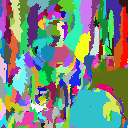

In [144]:
colors = [Images.ColorTypes.RGB(rand(), rand(), rand()) for _ in 1:num_s]
mask = [colors[s[i]] for i in 1:g.num_nodes]
mask = reshape(mask, dims) 

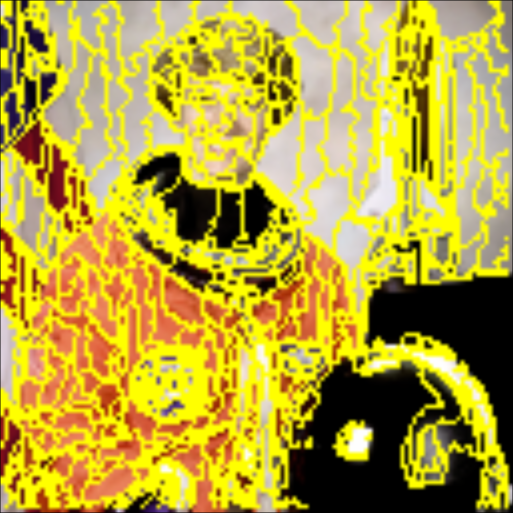

In [168]:
using  ColorVectorSpace, ColorTypes, Images
boundaries = reshape(s, dims)
boundaries_mask = ones(dims)
for j in 1:dims[2]-1
    for i in 1:dims[1]-1
        if boundaries[i, j] != boundaries[i+1, j]
            boundaries_mask[i, j] = 0
        end
        if boundaries[i, j] != boundaries[i, j+1]
            boundaries_mask[i, j] = 0
        end
    end
end

Images.imresize(img .* boundaries_mask + fill(RGB(1, 1, 0),dims) .* (1 .- boundaries_mask), (1024, 1024))

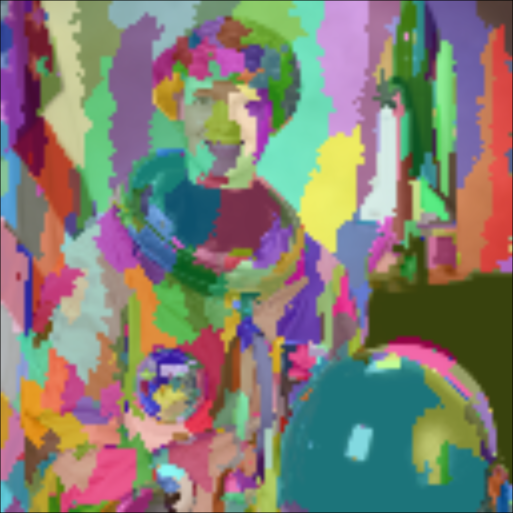

In [148]:
Images.imresize(0.4 .* img .+ 0.6 .* mask, (1024, 1024))

# Probabilistic Felzenszwalb

## Segment operations

In [1]:
using  SparseArrays
using  BenchmarkTools 

N = 128 * 128
k = 300/255

1.1764705882352942

Representing S as a dense vector of SparseVector

In [202]:
function initialize_structures(N::Int) 
    S = Vector{SparseVector{Float64, Int64}}(undef, N) 
    segment_hash = Dict{Int64, Vector{Int64}}(zip(1:N, [i] for i in 1:N))
    segment_size = ones(Float64, N)
    internal_diff = zeros(Float64, N)
    for i in 1:N
        S[i] = sparsevec([i], [1.0], N)
    end
    return S, segment_hash, segment_size, internal_diff
end

S, segment_hash, segment_size, internal_diff = initialize_structures(N)

@btime initialize_structures(N)

  5.181 ms (163853 allocations: 9.91 MiB)


(SparseVector{Float64, Int64}[  [1]  =  1.0,   [2]  =  1.0,   [3]  =  1.0,   [4]  =  1.0,   [5]  =  1.0,   [6]  =  1.0,   [7]  =  1.0,   [8]  =  1.0,   [9]  =  1.0,   [10]  =  1.0  …    [16375]  =  1.0,   [16376]  =  1.0,   [16377]  =  1.0,   [16378]  =  1.0,   [16379]  =  1.0,   [16380]  =  1.0,   [16381]  =  1.0,   [16382]  =  1.0,   [16383]  =  1.0,   [16384]  =  1.0], Dict(15380 => [15380], 11950 => [11950], 4700 => [4700], 4576 => [4576], 6073 => [6073], 15889 => [15889], 1703 => [1703], 12427 => [12427], 7685 => [7685], 14288 => [14288]…), [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Access segment and vertice information

With Vector of SparseVector

In [9]:
# get segments
ci = [2,3,4]
Ci = @view S[ci]

@btime Ci = @view S[ci]

  27.928 ns (1 allocation: 48 bytes)


3-element view(::Vector{SparseVector{Float64, Int64}}, [2, 3, 4]) with eltype SparseVector{Float64, Int64}:
   [2]  =  1.0
   [3]  =  1.0
   [4]  =  1.0

In [8]:
v = S[1]
vi = 1
@btime @inbounds cs = [c for c in segment_hash[vi] if S[c][vi] > 0.0]

  627.171 ns (7 allocations: 288 bytes)


1-element Vector{Int64}:
 1

In [251]:
v = S[1]
vi = 1
@btime @inbounds cs = [c for c in collect(segment_hash[vi]) if S[c][vi] > 0.0]

  618.448 ns (9 allocations: 368 bytes)


1-element Vector{Int64}:
 1

In [11]:
@btime @inbounds [c for c in 1:length(S) if S[c][1] > 0.0]

  1.001 ms (48648 allocations: 1016.33 KiB)


1-element Vector{Int64}:
 1

In [247]:
get_segments(S::Vector{SparseVector{Float64, Int64}}, cs::AbstractVector) = @view S[cs]

get_segments_from_vertices(S::Vector{SparseVector{Float64, Int64}}, vi::Int) = @inbounds [c for c in 1:length(S) if S[c][vi] > 0.0]

function get_segments_from_vertices(S::Vector{SparseVector{Float64, Int64}}, segment_hash::Dict{Int64, Vector{Int64}}, vi::Int) 
    V_I = @inbounds segment_hash[vi]
    V_K = [S[i][vi] for i in V_I]
    return V_I, V_K
end

function get_segments_from_vertices(S::Vector{SparseVector{Float64, Int64}}, segment_hash::Dict{Int64, Set{Int64}}, vi::Int) 
    V_I = @inbounds collect(segment_hash[vi])
    V_K = [S[i][vi] for i in V_I]
    return V_I, V_K
end

get_segments_from_vertices (generic function with 3 methods)

In [248]:
get_segments_from_vertices(S, segment_hash, 1)

([1], [1.0])

### Merge operation

$M_{ij}$ denotes the event of the merging of segments $C_i$ and $C_j$ into $C_i$. We have $P(M_{ij})$.
Considering that each $v \in C_i$ is the probability that $v$ belongs to $C_i$

If $M_{ij}$ is true:
$$ C_i = C_i + C_j $$ 
$$ C_j = \vec{0} $$

![](resources/merge_verticewise.png)

![](resources/belonging-to-seg-prob.png)

Here, $C_i^v$ is the event in which the node $v$ belongs to the segment $C_i$. 
And $P(C_i^v | S^t)$ is the probability that $C_i^v$ is true given the segment attribution matrix at time $t$. In this example, $o_t = (u, v)$

Otherwise, $C_i$ and $C_j$ remain unchanged.

However! Many merges are being computed at once. So for each vertice, it's more like

![](resources/seg-prob-global.png)

We can call $M_i^-$ the event where the segment $C_i$ is absorbed by another segment, whichever it may be (ie, the red regions) 

$$ M_i^- = \bigvee_{j \neq i} M_{ji}$$

Therefore 
$P(M_i^-)$ is the probabilty that the node $v$ will not belong to the segment $C_i$ in the next timestep.
$$P(M_i^-) = \sum_{j \neq i} P(M_{ji}) $$

Conversely, we can call $M_i^+$ the event where any segment is absorbed by $C_i$ (the green regions)

$$ M_i^+ = \bigvee_{j \neq i} M_{ij}$$
$P(M_i^+)$ is the probabilty that the node $v$ will belong to the segment $C_i$ in the next timestep if it belongs to any $C_j$ merged with $C_i$.
$$P(M_i^+) = \sum_{j \neq i} P(M_{ij}) $$

The probability of a node $v$ belonging to the $i$-th segment at time $q$ is: $C_i^v(q)$.

$C_i^v(q+1)$ is true if:

$$ (C^v_i(q) \wedge \neg M_i^-) \vee \bigvee_{j  \neq i} \big( M_{ij} \wedge C_j^v(q)\big)$$

$$P(C_i^v(q+1)) = P(C^v_i(q))(1 - P(M_i^-)) + \sum_{j \neq i} P(M_{ij})P(C_j^v(q))$$

$$P(\neg{C_i^v(q+1)})= \sum_{j\neq i} P(M_{ji})P(C_i^v(q))$$ 

$C^v_i$ and $C^v_j$ are disjoint at any given moment, so the probability is always $\in [0.0, 1.0]$
When $v$ is such that $o_q = (v, u)$ or $o_q = (u,v)$, $M_{ij}$ already assumes that $v$ belongs to 
the segment $i$ or $j$. Calculating the probability like described above would be incorrect. :(

Initially we have $P(M_{ij}| C_i^v \wedge C_j^u)$

![](resources/merge-prob-single.png)

$$ P(M_{ij} | C_i^v \wedge C_j^u) = \frac{P(M_{ij} \wedge (C_i^v \wedge C_j^u))}{P(C_i^v \wedge C_j^u)}$$
$$ P(M_{ij} | C_i^v \wedge C_j^u) = \frac{P(M_{ij})}{P(C_i^v)P(C_j^v)} $$
$$ P(M_{ij})= P(M_{ij} | C_i^v \wedge C_j^u) P(C_i^v)P(C_j^v) $$

We also have that 

$$ P(M_{ij} | C_i^v ) = \frac{P(M_{ij} \wedge C_i^v)}{P(C_i^v)}$$
$$ P(M_{ij} | C_i^v ) = \frac{P(M_{ij})}{P(C_i^v)}$$
$$ P(M_{ij} | C_i^v ) = \frac{P(M_{ij} | C_i^v \wedge C_j^u) P(C_i^v)P(C_j^u)}{P(C_i^v)}$$
$$ P(M_{ij} | C_i^v ) = P(M_{ij} | C_i^v \wedge C_j^u) P(C_j^u)$$

Likewise for $P(M_{ij}| C_j^u)$. 

If the edge we are considering in this timestep $q$ is $o(q) = (v, u)$, there are the following cases to consider 

![](resources/merge-v.png)

We want to know the probability of $v$ belonging to segment $i$ at the timestep $q+1$. Since there is no chance of the node $v$ being alocated to another segment through merging, 

$$P(C_i^v(q+1)) = P(C_i^v(q)) $$

![](resources/merge-u.png)

We want to know the probability that $u$ will belong to the segment $j$ at the next timestep. That will be the probability that $u$ belongs to the segment $j$ and, given that, the segment $j$ is not merged into anything else. 

$$ C_j^u(q+1) \leftarrow \neg M_j^- \cap C_j^u(q)$$


$$ P(C_j^u(q+1)) = P\Big(C_j^u(q)\Big)  P\Big(\neg M_{j}^- | C_j^u(q) \Big) $$

$$ P(C_j^u(q+1)) = P(C_j^u(q)) \bigg(1 - \sum_{i \neq j} P\Big(M_{ij} | C_j^u(q)\Big)\bigg) $$
$$ P(C_j^u(q+1)) = P(C_j^u(q)) \bigg(1 - \sum_{i \neq j} P(M_{ij} | C_i^v \wedge C_j^u) P(C_i^v)\bigg) $$
$$ P(C_j^u(q+1)) = P(C_j^u(q)) - \sum_{i \neq j} P\Big(M_{ij} | C_i^v(q) \wedge C_j^u(q)\Big) P\Big(C_i^v(q)\Big)P\Big(C_j^u(q)\Big) $$
$$ P(C_j^u(q+1)) = P(C_j^u(q)) - \sum_{i \neq j} P(M_{ij}) $$

![](resources/merge-t.png)

We want to know what's the probability that the node $t$, such that $t \notin [v,u]$,will belong to the segment $j$ in the next timestep.

$$ C^t_j(q+1) \leftarrow C^t_j(q) \cap \neg M_j^- $$

The event where $j$ is merged into another segment can be considered independent of the event where $t$ belongs to the segment $j$.

$$P\big(C^t_j(q+1)\big) = P\big(C^t_j(q)\big) P\big(\neg M_j^-\big)$$
$$P\big(C^t_j(q+1)\big) = P\big(C^t_j(q)\big) \big(1 - P\big(M_j^-\big)\big)$$
$$P\big(C^t_j(q+1)\big) = P\big(C^t_j(q)\big) \Bigg(1 - \sum_{i\neq j}P\big(M_{ij}\big)\Bigg)$$

We also want to know the probability of $t$ belonging to $i$ in the next timestep. 

$$ C^t_i(q+1) \leftarrow  C^t_i(q) \cup \neg C^t_i(q)\Bigg(\bigvee_{j \neq i} M_{ij}C^t_j(q)\Bigg) $$
$$P\big(C^t_i(q+1)\big) = P\big(C_i^t(q)\big) + \Big(1-P\big(C_i^t(q)\big)\Big) \Bigg(\sum_{j \neq i}P\big(M_{ij}\big)P\big(C_j^t(q)\big)\Bigg)$$

#### TL;DR

For any node $t | t \notin (v, u)$, 


$$ C^t_j(q+1) \leftarrow C^t_j(q) \cap \neg M_j^- $$
$$P\big(C^t_j(q+1)\big) = P\big(C^t_j(q)\big) \Bigg(1 - \sum_{i\neq j}P\big(M_{ij}\big)\Bigg)$$
and, 
$$ C^t_i(q+1) \leftarrow  C^t_i(q) \cup \neg C^t_i(q)\Bigg(\bigvee_{j \neq i} M_{ij}C^t_j(q)\Bigg) $$
$$P\big(C^t_i(q+1)\big) = P\big(C_i^t(q)\big) + \Big(1-P\big(C_i^t(q)\big)\Big) \Bigg(\sum_{j \neq i}P\big(M_{ij}\big)P\big(C_j^t(q)\big)\Bigg)$$

The node $v$ will necessarily remain in the same segment. For $u$:

$$ C_j^u(q+1) \leftarrow \neg M_j^- \cap C_j^u(q)$$
$$ P\big(C_j^u(q+1)\big) = P\big(C_j^u(q)\big) - \sum_{i \neq j} P\big(M_{ij}\big) $$

The difference in treatment of the nodes $u$ and $t$ comes from the fact that $C^t_j$ and $M_{ij} | i \neq j$ are independent, while  $M_{ij}$ depends on the fact that $C^u_j$. 

```julia
Cj_off = -Cj .* sum(P[:, j])
Cj_off[u] *= Cj[u]

Ci_off = (1 - Ci) .* P*Cj
```

In [89]:
# v, u = 1, 2
# V_I, V_K = get_segments_from_vertices(S, segment_hash, v)
# U_I, U_K = get_segments_from_vertices(S, segment_hash, u)
# P = merge_probability(V_I, V_K, U_I, U_K, internal_diff, k)
v, u = 1, 2
nv = 5
nu = 4
V_I = rand(1:N, nv)
V_K = rand(nv)
U_I = rand(1:N, nu)
U_K = rand(nu)
P = rand(nu, nv) #column operations are faster


4×5 Matrix{Float64}:
 0.510031  0.288076  0.78371   0.361432  0.635886
 0.759024  0.038433  0.825278  0.663708  0.719201
 0.525658  0.511415  0.628672  0.234947  0.548341
 0.406936  0.118299  0.548955  0.556478  0.997799

In [90]:
Ci = @view S[V_I]
Cj = @view S[U_I]

Cj_off = -Cj .* sum(P, dims=2)
fix_u!(C, C_off, u) = C_off[u] *= C[u]
fix_u!.(Cj, Cj_off, u)
Cj_off

4×1 Matrix{SparseVector{Float64, Int64}}:
   [6303]  =  -2.57913
   [4140]  =  -3.00564
   [5764]  =  -2.44903
   [4221]  =  -2.62847

In [164]:
not(C) = dropzeros(sparsevec(C.nzind, 1 .- C.nzval, N))
spmult(A, B) = sparsevec(cat(A.nzind, B.nzind, dims=1), cat(A.nzval, B.nzval, dims=1), N, *)
Ci_off = spmult.(not.(Ci), [sum(col .* Cj) for col in eachcol(P)])
@btime spmult.(not.(Ci), [sum(col .* Cj) for col in eachcol(P)])

  28.968 μs (420 allocations: 32.23 KiB)


5-element Vector{SparseVector{Float64, Int64}}:
   [2   ]  =  0.5
  [3   ]  =  0.5
  [4   ]  =  0.5
  [123 ]  =  0.510031
  [4140]  =  0.759024
  [4221]  =  0.406936
  [5764]  =  0.525658
  [6303]  =  0.510031
   [123 ]  =  0.288076
  [4140]  =  0.00576496
  [4221]  =  0.118299
  [5764]  =  0.511415
  [6303]  =  0.288076
   [123 ]  =  0.78371
  [4140]  =  0.825278
  [4221]  =  0.548955
  [5764]  =  0.628672
  [6303]  =  0.78371
   [123 ]  =  0.361432
  [4140]  =  0.663708
  [4221]  =  0.556478
  [5764]  =  0.234947
  [6303]  =  0.361432
   [123 ]  =  0.635886
  [4140]  =  0.719201
  [4221]  =  0.997799
  [5764]  =  0.548341
  [6303]  =  0.635886

#### Internal differences and segment sizes

If segment $j$ is merged into the segment $i$, $I_i(q+1) = w$. If not, it will remain the same. Therefore we can define the expected value of $I_i$ at the next timestep as:

$$ E\big(I_i(q+1)\big) = \Big(1-P\big(M_i^+\big)\Big) E\big(I_i(q)) + P\big(M_i^+)w $$

We can argue that, when there is a merge, the segment $j$ can be interpreted as a subset of the larger segment $i$, and can continue to have the same internal difference -- as it makes no sense to talk about the internall diference of an empty segment.  

In [192]:
Vi_I = rand(1:N, nv)
Vj_I = rand(1:N, nu)
w = rand()

0.9144995077899217

In [203]:
Mi = sum(P, dims=1)'
internal_diff[Vi_I] = (1 .- Mi) .* internal_diff[Vi_I] + Mi .* w
@btime (1 .- Mi) .* internal_diff[Vi_I] + Mi .* w

  270.668 ns (7 allocations: 480 bytes)


5×1 Matrix{Float64}:
 -0.40600019393921905
  0.9127469932157808
 -2.004578426885372
  0.3047309867824599
 -2.391106948328966

If segment $j$ is merged into segment $i$, the size of segment $j$ will remain the same as a subset of the segment $i$, if we are following the same logic used to determine the internal difference. Likewise, the expected size of the segment $i$ at the next timestep will be: 


$$ E\big(|C_i|(q+1)\big) = \ E\big(|C_i|(q)\big) + \sum_{j \neq i} P\big(M_{ij}\big)  E\big(|C_j|(q)\big)$$

In [205]:
segment_size[Vi_I] .+= [sum(col .* segment_size[Vj_I]) for col in eachcol(P)]
@btime [sum(col .* segment_size[Vj_I]) for col in eachcol(P)]

  1.332 μs (31 allocations: 1.80 KiB)


5-element Vector{Float64}:
 2.201648408754255
 0.9562236970590907
 2.7866155394008802
 1.816565002083197
 2.9012263991924225

## Merge probability

With $o_q = (v_i, v_j)$, we want the merge probability of each segment to which $v_i$ may belong and every segment to which $v_j$ may belong

$ P(V_i, V_j | S) \in R^{N \times N}$, where $V_i, V_j \in R^N$, $S \in R^{N \times N}$, $N = |V|$

<!-- $$ sigmoid\left(\frac{MInt(C_i^{q-1},C_j^{q-1})}{w(o_q)}-1\right)$$ -->
$$ P(M_{i,j}) = sigmoid\left(MInt(C_i,C_j)-w(o_q)\right)$$

With,

$$ MInt(C_i, C_j) = \min(Int(C_i) + \tau(C_i), Int(C_j) + \tau(C_j))  \in R^{N \times N}$$

where
$$\tau(V_i) = \frac{k}{\{|C_i| \forall i \in V_i\}} \in R^N$$


$MInt$ has to be computed between all combinations of $C_i \forall i \in V_i$ and $C_j \forall j \in V_j$

$P(M_{ij})$ is the merge probabilty of the segments $C_i$ and $C_j$ via the $o_q$ edge. However, $C_i$ and $C_j$ will be linked through $o_q$ only if $v_i \in C_i \wedge v_j \in C_j$ for $o_q = (v_i, v_j)$. So we are actually computing the conditional probability of $M_{ij}$ given that $v_i \in C_i \wedge v_j \in C_j$ is true.

$$ P(M_{ij} | v_i \in C_i \wedge v_j \in C_j) = sigmoid\left(MInt(C_i,C_j)-w(o_q)\right)$$

Therefore the actual 
$$ P(M_{ij} ) = sigmoid\left(MInt(C_i,C_j)-w(o_q)\right)P(v_i \in C_i)P(v_j \in C_j)$$

![](resources/merge_probability.png)

This is a visual intuition for the probability matrix. The main diagonal will always be zero. 

![](resources/prob-matrix.png)

In [ ]:
collect(Iterators.product([1,2,3], [4,5,6]))

In [85]:
using NNlib: σ

function merge_probability(Vi_I, Vi_K, Vj_I, Vj_K, w, k)
    τ(V_I, k) = k./segment_size[V_I]
    MInt = minimum.(
        Iterators.product(internal_diff[Vi_I] .+ τ(Vi_I, k), 
                          internal_diff[Vj_I] .+ τ(Vj_I, k)))
    Mij_conditional = σ.(MInt .- w)
    Mij = Mij_conditional .* (Vi_K * Vj_K')
    return Mij
end

vi, vj = 1, 2
w = rand()

# Vi_I, Vi_K = get_vertices(S, segment_hash, vi)
# Vj_I, Vj_K = get_vertices(S, segment_hash, vj)

Vi_I = rand(1:N, 101)
Vi_K = rand(101)
Vj_I = rand(1:N, 100)
Vj_K = rand(100)

P = merge_probability(Vi_I, Vi_K, Vj_I, Vj_K, w, 300/255)
@btime merge_probability(Vi_I, Vi_K, Vj_I, Vj_K, w, 300/255)

  100.029 μs (33 allocations: 481.22 KiB)


101×100 Matrix{Float64}:
 0.415008    0.568748    0.301979    …  0.222441   0.264658    0.13146
 0.0985571   0.135068    0.0717146      0.0528258  0.0628516   0.0312195
 0.0518985   0.0711243   0.0377637      0.0278171  0.0330966   0.0164397
 0.327789    0.449218    0.238514       0.175692   0.209037    0.103832
 0.1254      0.171854    0.0912466      0.0672132  0.0799696   0.0397224
 0.0906545   0.124238    0.0659643   …  0.04859    0.057812    0.0287162
 0.270919    0.371281    0.197133       0.14521    0.17277     0.0858179
 0.355243    0.486843    0.258491       0.190407   0.226545    0.112529
 0.258106    0.353722    0.18781        0.138343   0.164599    0.0817592
 0.305301    0.418399    0.222151       0.163639   0.194695    0.0967088
 ⋮                                   ⋱                         
 0.223866    0.306798    0.162895       0.11999    0.142763    0.0709132
 0.00713015  0.00977151  0.00518822     0.0038217  0.00454702  0.00225859
 0.0339027   0.046462    0.0246692    

In [87]:
P[1,:]

100-element Vector{Float64}:
 0.4150081587541928
 0.5687479470652254
 0.30197859788289017
 0.5248180470574173
 0.18438877714888272
 0.3320366578240237
 0.586575516285633
 0.12406489390369232
 0.28883551169013155
 0.28064447781065444
 ⋮
 0.18698275091119973
 0.5145931256028444
 0.2849231908709488
 0.09284629249125319
 0.27184615151625946
 0.36278623463750104
 0.22244075704704083
 0.2646577819402527
 0.1314603378749738